In [2]:
import os,csv,json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import SimpleITK as sitk
import tifffile as tif
import seaborn as sns
sys.path.append("/home/emilyjanedennis/Desktop/GitHub/rat_BrainPipe/")
from tools.analysis.transform_points import transform_points

In [3]:
77540/20

3877.0

In [32]:
basepath = "/home/emilyjanedennis/Desktop/cm2/"
brainname = "a253_488_filt.npy"
brainpath = os.path.join(basepath,brainname)
#channel = "ch_488"
#filename = "_ch01_cells_filtered.npy"
#fullfilename = os.path.join(brainpath,filename)
fulldf = pd.DataFrame(np.load(brainpath))
outputfolder= os.path.join(basepath,"output_{}".format(brainname[:-4]))
transformfolder = "/home/emilyjanedennis/LightSheetData/lightserv/pbibawi/pb_udisco_647_488_4x/pb_udisco_647_488_4x-007/imaging_request_1/rawdata/resolution_3.6x/elastix_inverse_transform//"

# SIGMA annotations 
annotation_volume_filename = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/SIGMA_in_mPRA.tif" 
annotation_labels = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/SIGMA_good_labels.csv"


#MRIr annotations 
#annotation_volume_filename= "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/WHS_SD_rat_T2star_v1.01_atlas.tif"
#annotation_labels = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/labels_v3.csv"
# see next cell for details!
# optional resampling between fullsized and input to elastix
#    ***Assumes ZYX and that any orientation changes have already been done.***
original_dims = (3877, 10546, 7570)  # original data zyx
resample_dims = (865, 1610, 539)  # sagittal atlas zyx SHOULD BE reg_downsized_for_atlas.tif size 
#resample_dims = (591,1006,392)

switch_x_and_z = 1 #takes zyx points from full size axial data and turns them into sagittal
if switch_x_and_z: 
    original_dims = (original_dims[2],original_dims[1],original_dims[0])  

### notes on orientations 

#### full size data is USUALLY but not always
    z planes: typically ~600, and going axially from  above -> below brain (e.g. 606)
    y = 8701 AP nose to cerebellum
    x = 7341 ML left to right
-- this is what CM2 sees (the _fullsizedata/ch00_ folder, for example)
    need to change the x and z axes 

#### then it's resampled for elastix to sagittal
    z = 591 left to right ML
    y = 1006 nose to cerebellum 
    x = 392 above to below
    
#### it could also be resized for elastix to be 140% of MRIr 
    z = 637 left to right ML
    y = 1084 nose to cerebellum
    x = 423 above to below

In [33]:
outputfolder

'/home/emilyjanedennis/Desktop/cm2/output_a253_488_filt'

In [34]:
#only have to do once
os.mkdir(outputfolder)

FileExistsError: [Errno 17] File exists: '/home/emilyjanedennis/Desktop/cm2/output_a253_488_filt'

In [37]:
fulldf = fulldf.apply(pd.to_numeric, errors='coerce')
fulldf

,z,y,x,size,source,bkrd
0,730,4960,1580,13,1412071.0,1412071.0
1,730,5074,1580,11,1412073.0,1412073.0
2,739,4758,1580,9,1430087.0,1430087.0
3,748,4735,1580,9,1449484.0,1449484.0
4,760,4635,1580,8,1472944.0,1472944.0
...,...,...,...,...,...,...
20895505,6843,4734,1274,8,84857278.0,84857278.0
20895506,6848,4759,1274,7,84864144.0,84864144.0
20895507,6850,4738,1274,15,84866903.0,84866903.0
20895508,6852,5005,1274,9,84869780.0,84869780.0


In [40]:
if switch_x_and_z: 
    fulldf.columns = ['z','y','x','size','source','bkrd']

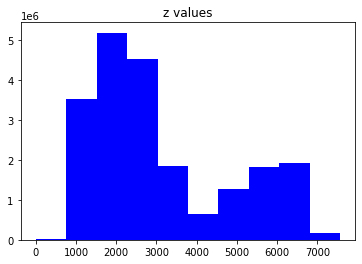

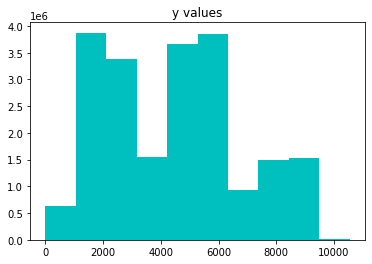

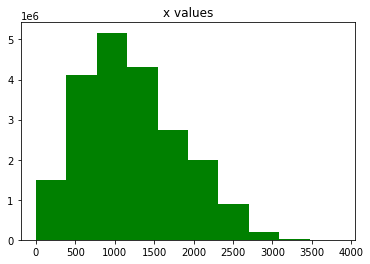

In [41]:
# plot summary data, helps make sure axes are correct and good to see 
subdf = fulldf[['z','y','x']]
npdf = subdf.to_numpy()
plt.hist(npdf[:,0],color='b')
plt.title('z values')
plt.show()
plt.hist(npdf[:,1],color='c')
plt.title('y values')
plt.show()
plt.hist(npdf[:,2],color='g')
plt.title('x values')
plt.show()

In [42]:
npdf_filename = "{}{}_pdf.npy".format(os.path.join(outputfolder,"a253"),"488")
npdf_filename
np.save(npdf_filename,npdf)


In [43]:
transformfiles=[os.path.join(transformfolder,"TransformParameters.0.txt"),
               os.path.join(transformfolder,"TransformParameters.1.txt"),
               os.path.join(transformfolder,"TransformParameters.2.txt"),
               os.path.join(transformfolder,"TransformParameters.3.txt")]

resample_points = [original_dims, resample_dims]


In [44]:
transform_points(npdf_filename,outputfolder,transformfiles, resample_points)

This function assumes ZYX centers...
writing centers to transfomix input points text file......done writing centers

***********Starting Transformix***********b'\ntransformix is started at Sat Apr  3 21:51:38 2021.\n\nwhich transformix:   transformix\ntransformix runs at: emilyjanedennis-System-Product-Name\n  Linux 5.8.0-38-generic (x64), #43~20.04.1-Ubuntu SMP Tue Jan 12 16:39:47 UTC 2021\n  with 128512 MB memory, and 10 cores @ 3809 MHz.\nRunning transformix with parameter file "/home/emilyjanedennis/Desktop/cm2/output_a253_488_filt/order3_TransformParameters.3.txt".\n\nReading the elastix parameters from file ...\n\nInstalling all components.\nInstallingComponents was successful.\n\nELASTIX version: 5.000\nCommand line options from ElastixBase:\n-in       unspecified, so no input image specified\n-out      /home/emilyjanedennis/Desktop/cm2/output_a253_488_filt/\n-threads  unspecified, so all available threads are used\n-tp       /home/emilyjanedennis/Desktop/cm2/output_a253_488_fil

In [45]:
transformed = np.load(os.path.join(outputfolder,"posttransformed_zyx_voxels.npy"))
transformed

array([[240.963947, 590.970718,  12.680811],
       [242.886788, 600.901818,  11.697142],
       [237.660568, 573.996868,  15.246937],
       ...,
       [158.148689, 672.327028, 532.369252],
       [163.171271, 695.343896, 530.747251],
       [184.829169, 832.645911, 571.571154]])

In [46]:
annotation_volume=tif.imread(annotation_volume_filename)
labels = pd.read_csv(annotation_labels)

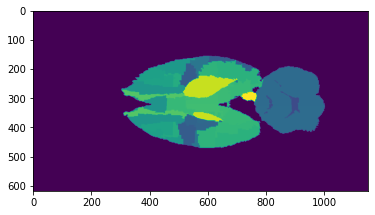

In [47]:
plt.imshow(annotation_volume[:,:,60])
plt.show()

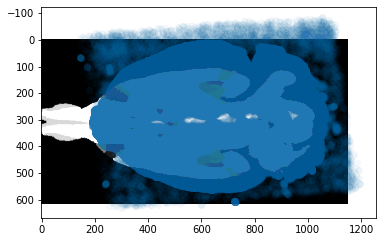

In [49]:
plt.imshow(annotation_volume[:,:,200],cmap='Greys_r', vmin=0, vmax=255)

plt.scatter(transformed[:,1],transformed[:,2],alpha=0.03)
plt.show()

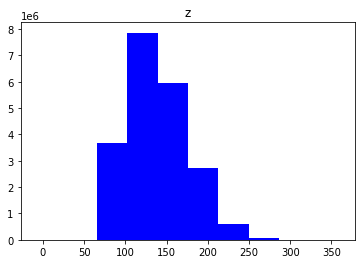

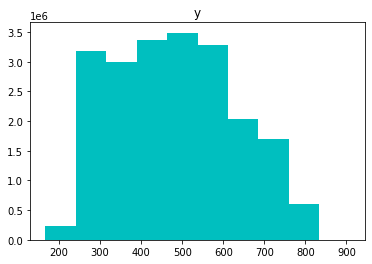

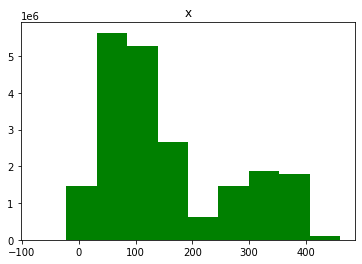

In [29]:
plt.hist(transformed[:,0],color='b')
plt.title("z")
plt.show()
plt.hist(transformed[:,1],color='c')
plt.title("y")
plt.show()
plt.hist(transformed[:,2],color='g')
plt.title("x")
plt.show()

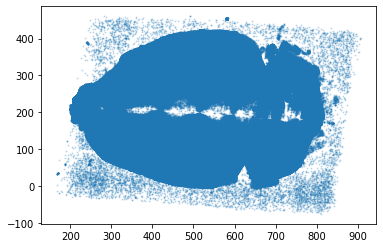

In [30]:
plt.scatter(transformed[:,1],transformed[:,2],s=1,alpha=0.2)
plt.show()

In [887]:
floort = np.floor(transformed)

In [888]:
masked_data = np.zeros(np.shape(annotation_volume))
np.shape(floort)

(304555, 3)

In [889]:
floortcopy=floort
np.max(floortcopy[:,0])

271.0

In [890]:
floort[:,1]=50+floort[:,1]
floort=floort[floort[:,0]<454]
floort=floort[floort[:,1]<773]
floort=floort[floort[:,2]<301]
floort=floort[floort[:,0]>0]
floort=floort[floort[:,1]>0]
floort=floort[floort[:,2]>0]

In [891]:
# for each row in transformed, place the value in edgevent in the correct space
for i in np.arange(0,np.shape(floort)[0]-1):
    x,y,z=floort[i,:]
    z=z.astype(int)
    y=y.astype(int)
    x=x.astype(int)
    if annotation_volume[x,y,z]>0:
        masked_data[x,y,z] = annotation_volume[x,y,z]

In [892]:
tif.imsave(os.path.join(brainpath,"{}_{}_eroded_results.tif".format(brainname,channel)),masked_data)

In [893]:
reshaped_masked=masked_data.reshape(np.size(masked_data),1)
np.shape(reshaped_masked)

(106355340, 1)

In [894]:
reshaped_masked=reshaped_masked[reshaped_masked>0]
max_masked = np.max(reshaped_masked)

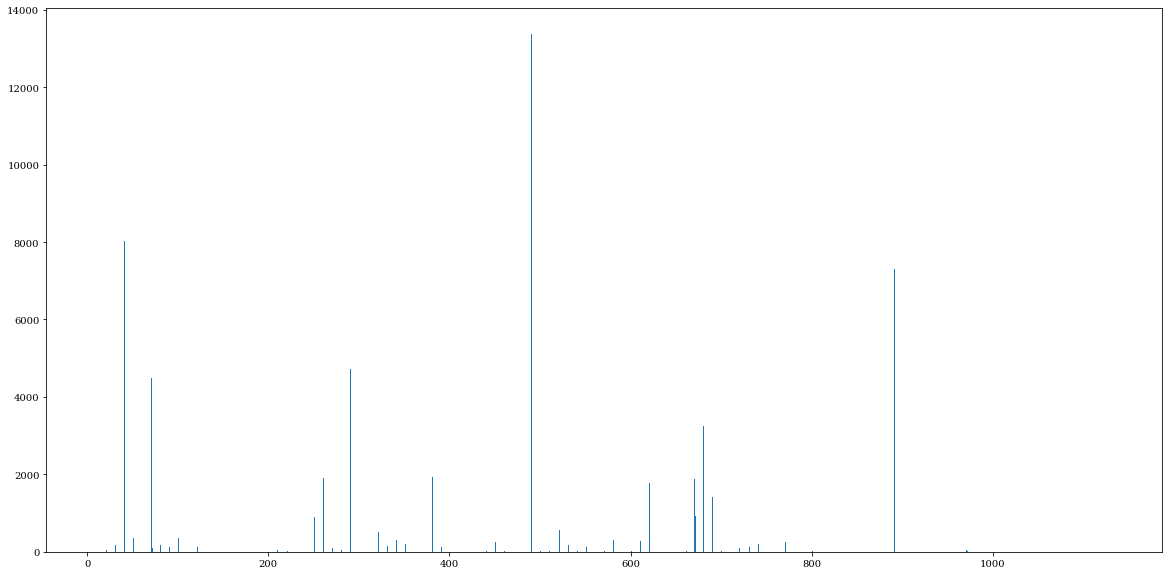

In [895]:
histinfo =plt.hist(reshaped_masked,bins=max_masked.astype(int))
plt.show()

In [896]:
labels.insert(3,'histinfo',0)

In [897]:
labels

,atlas,ID,label,histinfo
0,SIGMA,1171,Ventricular System,0
1,Waxholm,171,Globus Pallidus,0
2,Waxholm,731,Striatum,0
3,Waxholm,221,Granule Cell Level of the Cerebellum,0
4,Waxholm,341,Molecular Layer of the Cerebellum,0
...,...,...,...,...
229,Waxholm,882,Commissure of the Superior Colliculus,0
230,Waxholm,902,Deeper Layers of the Superior Colliculus,0
231,Waxholm,1082,SP5,0
232,Waxholm,792,Anterior Commissure Intrabulbar part,0


In [898]:
for i in np.arange(1,max_masked.astype(int)):
    labels.histinfo[labels.ID==i]=histinfo[0][i]

/home/emilyjanedennis/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [899]:
#calculating sigma info

In [900]:
annotation_volume_filename

'/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/SIGMA_annotation_50um_edge_50um_vent_erosion.tif'

In [901]:
np.shape(annotation_volume)

(455, 774, 302)

In [902]:
labels.insert(4,'vx_in_annotated_volume',0)

In [903]:
for i in labels.ID:
    labels.vx_in_annotated_volume[labels.index[labels.ID == i]] = np.size([annotation_volume[annotation_volume==i]])

/home/emilyjanedennis/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [904]:
totalcellcount = np.sum(labels.histinfo)

In [905]:
labels.insert(4,'percent_of_cells',0)
labels.insert(5,'percent_of_voxels',0)

In [906]:
for i in labels.index:
    labels.percent_of_cells[i] = 100*(labels.histinfo[i]/totalcellcount)
    labels.percent_of_voxels[i] = 100*(labels.histinfo[i]/labels.vx_in_annotated_volume[i])

/home/emilyjanedennis/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/emilyjanedennis/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/emilyjanedennis/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/emilyjanedennis/anaconda3/envs/lightsheet/lib/python3.7/site-

In [907]:
labels

,atlas,ID,label,histinfo,percent_of_cells,percent_of_voxels,vx_in_annotated_volume
0,SIGMA,1171,Ventricular System,0,0,NaN,0
1,Waxholm,171,Globus Pallidus,0,0,0.0,1867
2,Waxholm,731,Striatum,0,0,0.0,907108
3,Waxholm,221,Granule Cell Level of the Cerebellum,0,0,0.0,676465
4,Waxholm,341,Molecular Layer of the Cerebellum,0,0,0.0,2320922
...,...,...,...,...,...,...,...
229,Waxholm,882,Commissure of the Superior Colliculus,0,0,0.0,1641
230,Waxholm,902,Deeper Layers of the Superior Colliculus,0,0,0.0,262212
231,Waxholm,1082,SP5,0,0,0.0,14276
232,Waxholm,792,Anterior Commissure Intrabulbar part,0,0,0.0,25390


In [908]:
csvname = os.path.join(brainpath,"{}_{}_counts_SIGMA_50eroded.csv".format(brainname,channel))
labels.to_csv(csvname)

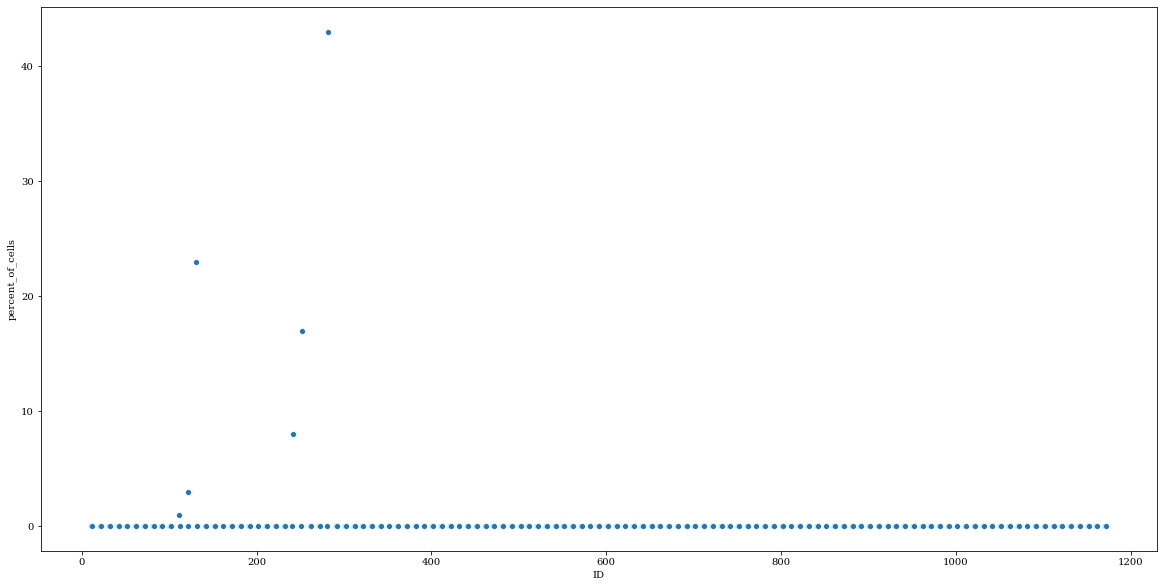

In [909]:
ax = sns.scatterplot(x='ID',y='percent_of_cells',data=labels)
plt.show()